In [1]:
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from stop_words import get_stop_words
import morfeusz2
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
with open("TweetsSample.json") as f:
  tweets = json.load(f)
print(tweets)

[{'searchHashtag': '#kwarantanna', 'id': '1344289927585017857', 'authorId': '2277773654', 'createdAt': '2020-12-30T15:31:09+01:00', 'hashtags': [{'start': 58, 'end': 65, 'tag': 'AD2020'}, {'start': 66, 'end': 74, 'tag': 'NowyRok'}, {'start': 81, 'end': 91, 'tag': 'Sylwester'}, {'start': 92, 'end': 100, 'tag': 'Szampan'}, {'start': 101, 'end': 107, 'tag': 'Party'}, {'start': 108, 'end': 120, 'tag': 'Kwarantanna'}, {'start': 121, 'end': 129, 'tag': 'COVID19'}, {'start': 130, 'end': 138, 'tag': 'Pidżama'}, {'start': 139, 'end': 147, 'tag': 'Domówka'}], 'urls': [{'displayUrl': 'minddrone.wordpress.com/2020/12/30/sza…', 'end': 171, 'expandedUrl': 'https://minddrone.wordpress.com/2020/12/30/szal-sylwestrowej-mody-czyli-mistrz-i-malgorzata-ad2020-2021/', 'start': 148, 'url': 'https://t.co/F3GCmMpfms', 'unwoundUrl': None}], 'text': 'Szał Sylwestrowej Mody czyli Propozycja Nie Do Odrzucenia #AD2020 #NowyRok #2021 #Sylwester #Szampan #Party #Kwarantanna #COVID19 #Pidżama\xa0#Domówka https://t.co

In [3]:
def remove_urls(tweet):
    modified_text = tweet['text']
    for url in tweet['urls']:
        if url:
            modified_text = modified_text.replace(url['url'], '')
    return modified_text

In [4]:
def remove_hashtags(tweet):
    modified_text = tweet['text']
    for tag in tweet['hashtags']:
        modified_text = modified_text.replace('#' + tag['tag'], '')
    return modified_text

In [5]:
for tweet in tweets:
    #print(tweet['text'])
    tweet['text'] = remove_hashtags(tweet)
    if tweet['urls']:
        tweet['text'] = remove_urls(tweet)
    tweet['text'] = tweet['text'].lower()
    tweet['text'] = "".join([c for c in tweet['text'] if (c.isalnum() or c==' ')])
    print(tweet['text'])

szał sylwestrowej mody czyli propozycja nie do odrzucenia   2021       
w jswsa odnotowano dziś 1 nowy przypadek zarażenia em w   od początku  zainfekowanych zostało 4591 pracowników  do dziś wyzdrowiało 4571 osób na  przebywa 51 osób
organy państwowej inspekcji sanitarnej od początku wprowadzenia obostrzeń związanych ze stanem epidemii wydały ponad 4500 decyzji o ukaraniu m in za łamanie zasad kwarantanny czy ograniczeń dot działalności gospodarczej  
hej niestety przez to że moja przyjaciółka ma covida sylwestra organizujemy online macie jakieś pomysły jak sobie zorganizować czas chętnie przyjmę wasze propozycje miłego  2020 2021    
informacje i szczegóły na    narodowa  jazzowy     w katowice poland 
chciałabym żeby jeszcze zaczęły mi się kręcić przy nasadzie ale wiem że trzeba czasu przez kwarantanne zaczęłam patrzeć inaczej na włosy i zrozumiałam że chcą się kręcićxd polecam spróbować serio    
w jswsa odnotowano dziś 1 nowy przypadek zarażenia em  w   od początku  zainfekowanych

In [6]:
#TODO regrding parsing -> remove annotations

In [7]:
#let's start with a basic one, there are maaaany others (just fyi)
def tokenize(tweet):
    if(tweet["searchHashtag"] == "#COVID19"):
        text = tweet['text'].strip()
        if not text:
            return []
        tokens = text.split()
        return tokens
    
#temporarily - only #COVID19
tokenized = [tokenize(tweet) for tweet in tweets if tokenize(tweet)]

print(tokenized)

[['microsoft', 'power', 'bi', 'agg', 'su', 'in'], ['na', 'zdjęciu', 'około', '½', 'kolejki', 'do', 'punktu', 'testowania', 'na', 'na', 'lotnisku', 'w', 'dresden', 'także', 'plany', 'na', 'wieczór', 'właśnie', 'się', 'wyklarowały'], ['szefernaker', 'pisorgpl', 'za', 'logistykę', 'szczepień', 'przeciwko', 'odpowiada', 'pisorgpl', 'solidarnapl', 'porozumienie', 'i', 'po', 'raz', 'kolejny', 'pokazuj', 'że', 'to', 'fikcja', 'użycie', 'przez', 'szefernaker', 'zwrotu', 'elity', 'iii', 'rp', 'ma', 'tylko', 'przykryć', 'ten', 'chaos', 'jest', 'jak', 'zawsze', 'improwizacja'], ['za', 'logistykę', 'szczepień', 'przeciwko', 'odpowiada', 'pisorgpl', 'solidarnapl', 'porozumienie', 'i', 'po', 'raz', 'kolejny', 'pokazuj', 'że', 'to', 'fikcja', 'użycie', 'przez', 'szefernaker', 'zwrotu', 'elity', 'iii', 'rp', 'ma', 'tylko', 'przykryć', 'ten', 'chaos', 'jest', 'jak', 'zawsze', 'improwizacja'], ['ja', 'się', 'kurcze', 'od', 'roku', 'martwię', 'antyszczepionkowcami', 'a', 'tu', 'od', 'tyłu', 'zaatakowali'

In [8]:
#needed to be extended in the future

stop_words = get_stop_words('polish')

In [9]:
tokenized_without_stop_words = [token for token in tokenized if token not in stop_words]

In [10]:
#lemmatization

morf = morfeusz2.Morfeusz()
lemmatized = [[morf.analyse(x)[0][2][1] for x in group] for group in tokenized_without_stop_words]

In [11]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for tokens in lemmatized:
    vectors.append(", ".join(tokens))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 3491)	1
  (0, 112)	1
  (0, 260)	1
  (0, 2692)	1
  (0, 1668)	1
  (1, 3337)	1
  (1, 4325)	1
  (1, 4130)	1
  (1, 1931)	1
  (1, 2505)	1
  (1, 3692)	1
  (1, 869)	1
  (1, 1568)	1
  (1, 1869)	1
  (1, 1876)	1
  (1, 4051)	1
  (1, 3788)	1
  (1, 2929)	1
  (1, 768)	1
  (1, 1353)	1
  (1, 2270)	1
  (1, 4496)	1
  (1, 1938)	1
  (2, 4470)	1
  (2, 1198)	1
  :	:
  (298, 2841)	1
  (298, 2867)	1
  (298, 412)	1
  (298, 2763)	1
  (298, 1747)	1
  (298, 3014)	1
  (299, 950)	1
  (299, 2600)	1
  (299, 691)	1
  (299, 476)	1
  (299, 1232)	1
  (299, 1589)	1
  (299, 4624)	1
  (299, 831)	1
  (299, 1173)	1
  (299, 4047)	1
  (299, 3237)	1
  (299, 2103)	1
  (299, 3748)	1
  (299, 1623)	1
  (299, 3746)	1
  (299, 833)	1
  (299, 234)	1
  (299, 4249)	1
  (299, 2266)	1


In [12]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 18, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = [i for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

In [13]:
df_document_topic

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Dominant_topic
0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.84,0.01,0.01,16
1,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7
2,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
3,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.96,0.00,0.00,0.00,15
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.94,0.00,17
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.00,0.00,16
7,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.91,18
8,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,13


In [14]:
# index names
docnames = ['Doc' + str(i) for i in range(len(tokenized))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
00 zaufać,17,1.055556
003 polski,11,1.055556
058 śmiertelny,11,1.055556
08164 zaszczepić,2,1.055556
099 zmiana,11,1.055556
10 lato,16,2.055556
10 milion,8,1.055556
10 procent,4,1.055556
10 światowy,5,1.055556
100 osoba,6,1.055556


In [15]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic']
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['dominant_topic', 'topic_name'])
display(all_topics)

,dominant_topic,topic_name
0,17,[co p1]
1,11,[wiadomo że]
2,2,[nowy rok]
3,16,[ponad 10]
4,8,[to być]
5,4,[szczepić przeciw]
6,5,[zaszczepić się]
7,6,[rok s1]
8,14,[tys s1]
9,13,[miller s1]


In [16]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\01131252\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()
clean_tweets = [tweet["text"] for tweet in tweets if (tweet["searchHashtag"] == "#COVID19")]
sentiment_score_list = []
sentiment_label_list = []

for i in clean_tweets:
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df_document_topic['sentiment'] = sentiment_label_list
df_document_topic['sentiment score'] = sentiment_score_list

display(df_document_topic.head(100))

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,dominant_topic,sentiment,sentiment score
Doc0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.84,0.01,0.01,15,Neutral,0.0000
Doc1,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,Neutral,0.0000
Doc2,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,Negative,-0.8074
Doc3,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,Negative,-0.8074
Doc4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.96,0.00,0.00,0.00,14,Neutral,0.0000
Doc5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.94,0.00,16,Neutral,0.0000
Doc6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.97,0.00,0.00,15,Neutral,0.0000
Doc7,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.91,17,Neutral,0.0000
Doc8,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,Neutral,0.0000
Doc9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.97,0.00,0.00,0.00,0.00,0.00,12,Neutral,0.0000


In [18]:
results = df_document_topic.groupby(['dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
co p1,3.0,20.0,NaN
dzień s1,NaN,7.0,NaN
miller s1,1.0,22.0,1.0
nie być,2.0,16.0,1.0
nowy rok,4.0,15.0,NaN
państwo s1,1.0,16.0,NaN
ponad 10,1.0,9.0,1.0
poza kolejność,2.0,8.0,NaN
rok s1,2.0,17.0,1.0


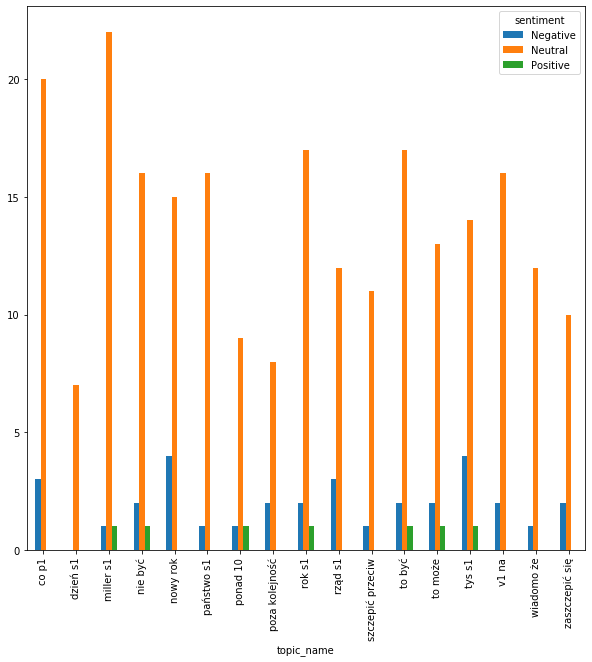

In [20]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))

In [ ]:
#next steps:
#for all the hashtags ofc
#extend stop word list
#consider some bugs created by lemmatisation
#remove mentions
#check this sentiment analyser  - sth is wrong there clearly
#experiment with different approaches to tokenization etc.
#include time trends
#clean up this playground mess